<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Timeseries Forecasting with LSTM on Stock Data

_Authors: Kiefer Katovich (SF)_

---

In this lab you will practice building LSTMs with Keras to fit and predict on timeseries data. In particular, you will be pulling down stock price data using a matplotlib package (code provided).

This lab mirrors in large part the Keras LSTM code in the lecture, so please see that for reference.

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### 1. Import the required Keras packages

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


### 2. Pull down the stock price data using `matplotlib.finance`

The code to pull the stock data is provided for you. This code will pull the daily close prices for a variety of companies in the year 2010. 

In [81]:
from matplotlib.finance import quotes_historical_yahoo_ochl
import datetime

symbol_dict = {
    'TOT': 'Total',
    'XOM': 'Exxon',
    'CVX': 'Chevron',
    'COP': 'ConocoPhillips',
    'VLO': 'Valero Energy',
    'MSFT': 'Microsoft',
    'IBM': 'IBM',
    'TWX': 'Time Warner',
    'CMCSA': 'Comcast',
    'CVC': 'Cablevision',
    'YHOO': 'Yahoo',
    'DELL': 'Dell',
    'HPQ': 'HP',
    'AMZN': 'Amazon',
    'TM': 'Toyota',
    'CAJ': 'Canon',
    'MTU': 'Mitsubishi',
    'SNE': 'Sony',
    'F': 'Ford',
    'HMC': 'Honda',
    'NAV': 'Navistar',
    'NOC': 'Northrop Grumman',
    'BA': 'Boeing',
    'KO': 'Coca Cola',
    'MMM': '3M',
    'MCD': 'Mc Donalds',
    'PEP': 'Pepsi',
    'MDLZ': 'Kraft Foods',
    'K': 'Kellogg',
    'UN': 'Unilever',
    'MAR': 'Marriott',
    'PG': 'Procter Gamble',
    'CL': 'Colgate-Palmolive',
    'GE': 'General Electrics',
    'WFC': 'Wells Fargo',
    'JPM': 'JPMorgan Chase',
    'AIG': 'AIG',
    'AXP': 'American express',
    'BAC': 'Bank of America',
    'GS': 'Goldman Sachs',
    'AAPL': 'Apple',
    'SAP': 'SAP',
    'CSCO': 'Cisco',
    'TXN': 'Texas instruments',
    'XRX': 'Xerox',
    'LMT': 'Lookheed Martin',
    'WMT': 'Wal-Mart',
    'WBA': 'Walgreen',
    'HD': 'Home Depot',
    'GSK': 'GlaxoSmithKline',
    'PFE': 'Pfizer',
    'SNY': 'Sanofi-Aventis',
    'NVS': 'Novartis',
    'KMB': 'Kimberly-Clark',
    'R': 'Ryder',
    'GD': 'General Dynamics',
    'RTN': 'Raytheon',
    'CVS': 'CVS',
    'CAT': 'Caterpillar',
    'DD': 'DuPont de Nemours'}

symbols, names = np.array(list(symbol_dict.items())).T

# Choose a time period (2008 crash in middle!)
d1 = datetime.datetime(2010, 1, 1)
d2 = datetime.datetime(2011, 1, 1)

quotes = [quotes_historical_yahoo_ochl(symbol, d1, d2, asobject=True)
          for symbol in symbols]

stock_close = {symb:q.close for symb, q in zip(symbols, quotes)}


### 3. Convert the stock closes to a dataframe and perform first-order differencing

This converts the data into daily changes in stock price.

In [82]:
stocks = pd.DataFrame(stock_close)

In [83]:
stocks.head()

,AAPL,AIG,AMZN,AXP,BA,BAC,CAJ,CAT,CL,CMCSA,...,TWX,TXN,UN,VLO,WBA,WFC,WMT,XOM,XRX,YHOO
0,27.727039,23.483886,133.899994,36.713605,46.814975,14.872177,42.311202,47.809265,34.934217,7.439745,...,23.953311,21.849255,25.534907,13.827652,32.020453,23.005477,45.002689,56.187171,4.797763,17.100000
1,27.774976,23.043907,134.690002,36.632860,48.348253,15.355595,42.643976,48.380853,35.216726,7.338912,...,23.684634,21.723251,24.914564,14.183201,31.762917,23.637033,44.554570,56.406554,4.803323,17.230000
2,27.333178,22.894628,132.250000,37.225014,49.814865,15.535691,42.595039,48.527833,35.136614,7.286303,...,23.627644,21.563644,24.697443,14.538743,31.522550,23.670717,44.454989,56.894077,4.758847,17.170000
3,27.282650,22.454649,130.000000,37.828760,51.831460,16.047545,41.410757,48.723805,34.997466,7.439745,...,23.383382,21.630847,24.294219,14.646960,31.711408,24.529632,44.479883,56.715323,4.781085,16.700001
4,27.464034,23.051764,133.520004,37.801727,51.331477,15.905364,41.097559,49.270898,34.369199,7.417825,...,23.415958,22.126466,24.619899,14.446000,31.754334,24.302273,44.255827,56.487807,4.764406,16.700001


In [84]:
stocks.shape

(252, 60)

In [85]:
sd = stocks.diff(1).dropna()

In [86]:
sd.head()

,AAPL,AIG,AMZN,AXP,BA,BAC,CAJ,CAT,CL,CMCSA,...,TWX,TXN,UN,VLO,WBA,WFC,WMT,XOM,XRX,YHOO
1,0.047937,-0.439979,0.790008,-0.080745,1.533278,0.483418,0.332774,0.571588,0.282509,-0.100833,...,-0.268677,-0.126004,-0.620343,0.355549,-0.257536,0.631556,-0.448119,0.219383,0.005560,0.130000
2,-0.441798,-0.149279,-2.440002,0.592154,1.466612,0.180096,-0.048937,0.146980,-0.080112,-0.052609,...,-0.056990,-0.159607,-0.217121,0.355542,-0.240367,0.033684,-0.099581,0.487523,-0.044476,-0.060000
3,-0.050528,-0.439979,-2.250000,0.603746,2.016595,0.511854,-1.184282,0.195972,-0.139148,0.153442,...,-0.244262,0.067203,-0.403224,0.108217,0.188858,0.858915,0.024894,-0.178754,0.022238,-0.469999
4,0.181384,0.597115,3.520004,-0.027033,-0.499983,-0.142181,-0.313198,0.547093,-0.628267,-0.021920,...,0.032576,0.495619,0.325680,-0.200960,0.042926,-0.227359,-0.224056,-0.227516,-0.016679,0.000000
5,-0.242276,0.227845,-3.210006,-0.432534,-0.608311,0.142181,0.127234,3.094739,-0.151796,-0.048225,...,0.333809,-0.285611,0.147333,-0.139133,0.051505,-0.050526,0.730264,0.633786,0.116748,0.039999


### 4. Select a handful of stock symbols to look at and subset the data.

In [129]:
# I'm selecting banks here (and AIG)
bank_names = {'WFC': 'Wells Fargo',
              'JPM': 'JPMorgan Chase',
              'AIG': 'AIG',
              'AXP': 'American express',
              'BAC': 'Bank of America',
              'GS': 'Goldman Sachs'}

In [130]:
bankdf = sd[[c for c in sd.columns if c in bank_names.keys()]]
bankdf.head()

,AIG,AXP,BAC,GS,JPM,WFC
1,-0.439979,-0.080745,0.483418,2.783459,0.696196,0.631556
2,-0.149279,0.592154,0.180096,-1.710105,0.201308,0.033684
3,-0.439979,0.603746,0.511854,3.101835,0.729749,0.858915
4,0.597115,-0.027033,-0.142181,-3.056351,-0.092268,-0.227359
5,0.227845,-0.432534,0.142181,-2.501477,-0.125819,-0.050526


### 5. Normalize the data to the range -1 to 1

In [91]:
mms = MinMaxScaler(feature_range=(-1,1))
bdfn = pd.DataFrame(mms.fit_transform(bankdf), columns=bankdf.columns)

In [92]:
bdfn.head()

,AIG,AXP,BAC,GS,JPM,WFC
0,0.036221,0.146591,0.517717,0.711127,0.452047,0.246000
1,0.094488,0.392600,0.264996,0.394333,0.219876,-0.134478
2,0.036221,0.396838,0.541410,0.733572,0.467788,0.390689
3,0.244095,0.166228,-0.003517,0.299423,0.082148,-0.300603
4,0.170079,0.017979,0.233407,0.338542,0.066408,-0.188068


### 6. Split the data into training and testing subsets

Make sure the test set is all future data (timepoints beyond the training data).

In [93]:
train_size = int(bdfn.shape[0] * 0.66)
test_size = bdfn.shape[0] - train_size
print bdfn.shape[0], train_size, test_size

train, test = bdfn.iloc[0:train_size,:], bdfn.iloc[train_size:,:]

251 165 86


### 7. Create an X and Y matrix where the predictor matrix X are the changes lagged one behind Y.

A cool aspect of LSTMs and neural network architectures in general is that it is trivial to fit models with multiple outputs.

Here our target will be a *matrix* of tomorrows price changes, and the predictors will be a matrix of todays stock changes. Thus we are going to optimize the neural network to minimize the error predicting the next stock change on all of the stocks at the same time!

Create the X and Y below.

In [94]:
def create_XY(df):
    Y = df.iloc[1:, :]
    X = df.iloc[:-1, :]
    return X.values, Y.values

In [95]:
Xtrain, Ytrain = create_XY(train)
Xtest, Ytest = create_XY(test)

In [96]:
print Xtrain.shape, Ytrain.shape

(164, 6) (164, 6)


### 8. Reshape the training and testing X to be 3D

Recall that the LSTM takes a tensor in format:

    [observations, timesteps, features]
    
We lagged this only 1, so we will only have 1 timestep per feature (we will be using a stateful LSTM for fitting so we don't actually need more than 1 timestep).

> *Hint: the `np.reshape` function can add the 3rd dimension to your data.*

In [97]:
# reshape input to be [samples, time steps, features]
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], 1, Xtrain.shape[1]))
Xtest = np.reshape(Xtest, (Xtest.shape[0], 1, Xtest.shape[1]))

### 9. Build a Keras LSTM model

Below is some code that will build an LSTM model for this forecasting problem:

```python
model = Sequential()
# Remember: "batch_input_shape" and specify the batch size
model.add(LSTM(32, batch_input_shape=(1, 1, Xtrain.shape[2]), stateful=True))
model.add(Dense(Xtrain.shape[2]))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
```

Some things to note:
- The `stateful=True` indicates that our LSTM layer is stateful and will need to be manually reset. This allows us to feed in all the observations sequentially and allow the LSTM to (possibly) find signal in temporal patterns.
- We have 32 LSTM neurons. The `batch_input_shape=(1, 1, Xtrain.shape[2])` specifies the expected input to this layer. There will be 1 observation at a time, with 1 timestep, and as many features as there are in Xtrain.
- The `model.add(Dense(Xtrain.shape[2]))` adds the final output layer with as many output neurons as there are features. When we fit the model we will be predicting the matrix Y that has the same number of columns. This is the portion that allows us to fit on multiple outputs.

In [98]:
# create and fit the LSTM network
model = Sequential()
# Remember: "batch_input_shape" and specify the batch size
model.add(LSTM(32, batch_input_shape=(1, 1, Xtrain.shape[2]), stateful=True))
model.add(Dense(Xtrain.shape[2]))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (1, 32)                   4992      
_________________________________________________________________
dense_4 (Dense)              (1, 6)                    198       
Total params: 5,190.0
Trainable params: 5,190
Non-trainable params: 0.0
_________________________________________________________________


### 10. Fit the stateful LSTM model

Below is code to help you fit the model outlined above:

```python
for i in range(100):
    if (i % 5) == 0:
        print 'ITER:', i
        model.fit(Xtrain, Ytrain, nb_epoch=1, batch_size=1, verbose=1, shuffle=False)
    else:
        model.fit(Xtrain, Ytrain, nb_epoch=1, batch_size=1, verbose=0, shuffle=False)
    model.reset_states()
```

Here we will iterate over the entire training data 100 times. Each time we will fit the model without shuffling the data, feeding in single observations sequentially (batch_size=1).

The if-else statement inside allows us to print out every 5 iterations. Notice the `model.reset_states()`. This is where we manually clear the internal state of the LSTM neurons after each pass through the data.

In [99]:
for i in range(100):
    if (i % 5) == 0:
        print 'ITER:', i
        model.fit(Xtrain, Ytrain, nb_epoch=1, batch_size=1, verbose=1, shuffle=False)
    else:
        model.fit(Xtrain, Ytrain, nb_epoch=1, batch_size=1, verbose=0, shuffle=False)
    model.reset_states()

ITER: 0
Epoch 1/1
164/164 [==============================] - 2s - loss: 0.0912     
ITER: 5
Epoch 1/1
164/164 [==============================] - 1s - loss: 0.0816     
ITER: 10
Epoch 1/1
164/164 [==============================] - 1s - loss: 0.0807     
ITER: 15
Epoch 1/1
164/164 [==============================] - 1s - loss: 0.0801     
ITER: 20
Epoch 1/1
164/164 [==============================] - 1s - loss: 0.0794     
ITER: 25
Epoch 1/1
164/164 [==============================] - 1s - loss: 0.0785     
ITER: 30
Epoch 1/1
164/164 [==============================] - 1s - loss: 0.0772     
ITER: 35
Epoch 1/1
164/164 [==============================] - 1s - loss: 0.0748     
ITER: 40
Epoch 1/1
164/164 [==============================] - 1s - loss: 0.0716     
ITER: 45
Epoch 1/1
164/164 [==============================] - 1s - loss: 0.0685     
ITER: 50
Epoch 1/1
164/164 [==============================] - 1s - loss: 0.0655     
ITER: 55
Epoch 1/1
164/164 [==============================] - 1s - 

### 11. Plot the forecast on the testing data

Plot out the testing data and the forecast from the LSTM prediction. You will need to predict on the X test data.

Remember that the LSTM is now making a prediction for each of the stocks, so the prediction will be a matrix. To plot an individual stock, you will need to pull out the column corresponding to that stock.

> **Note:** as this is a fairly challenging plotting problem, I have provided template plotting code below. It is similar to the plotting code outlined in the LSTM forecasting lecture.

In [122]:
from sklearn.metrics import r2_score

def plot_all(model, Xtrain, Xtest, Ytest, bdfn, bank_names):
    train_hat = model.predict(Xtrain, batch_size=1)
    model.reset_states()
    test_hat = model.predict(Xtest, batch_size=1)
    model.reset_states()
    
    train_plot = np.empty_like(bdfn.values)
    train_plot[:, :] = np.nan
    train_plot[1:Xtrain.shape[0]+1, :] = train_hat
    
    test_plot = np.empty_like(bdfn.values)
    test_plot[:, :] = np.nan
    test_plot[-Xtest.shape[0]:, :] = test_hat
    
    fig, axarr = plt.subplots(Ytest.shape[1], 1, figsize=(12,24))
    
    for i in range(Ytest.shape[1]):
        axarr[i].plot(bdfn.iloc[:,i], color='grey', alpha=0.7)
        axarr[i].plot(train_plot[:,i])
        axarr[i].plot(test_plot[:,i])
        test_r2 = r2_score(Ytest[:,i], test_hat[:,i])
        axarr[i].set_title(bank_names[bdfn.columns[i]]+' test R2: '+str(test_r2))
        
    plt.show()

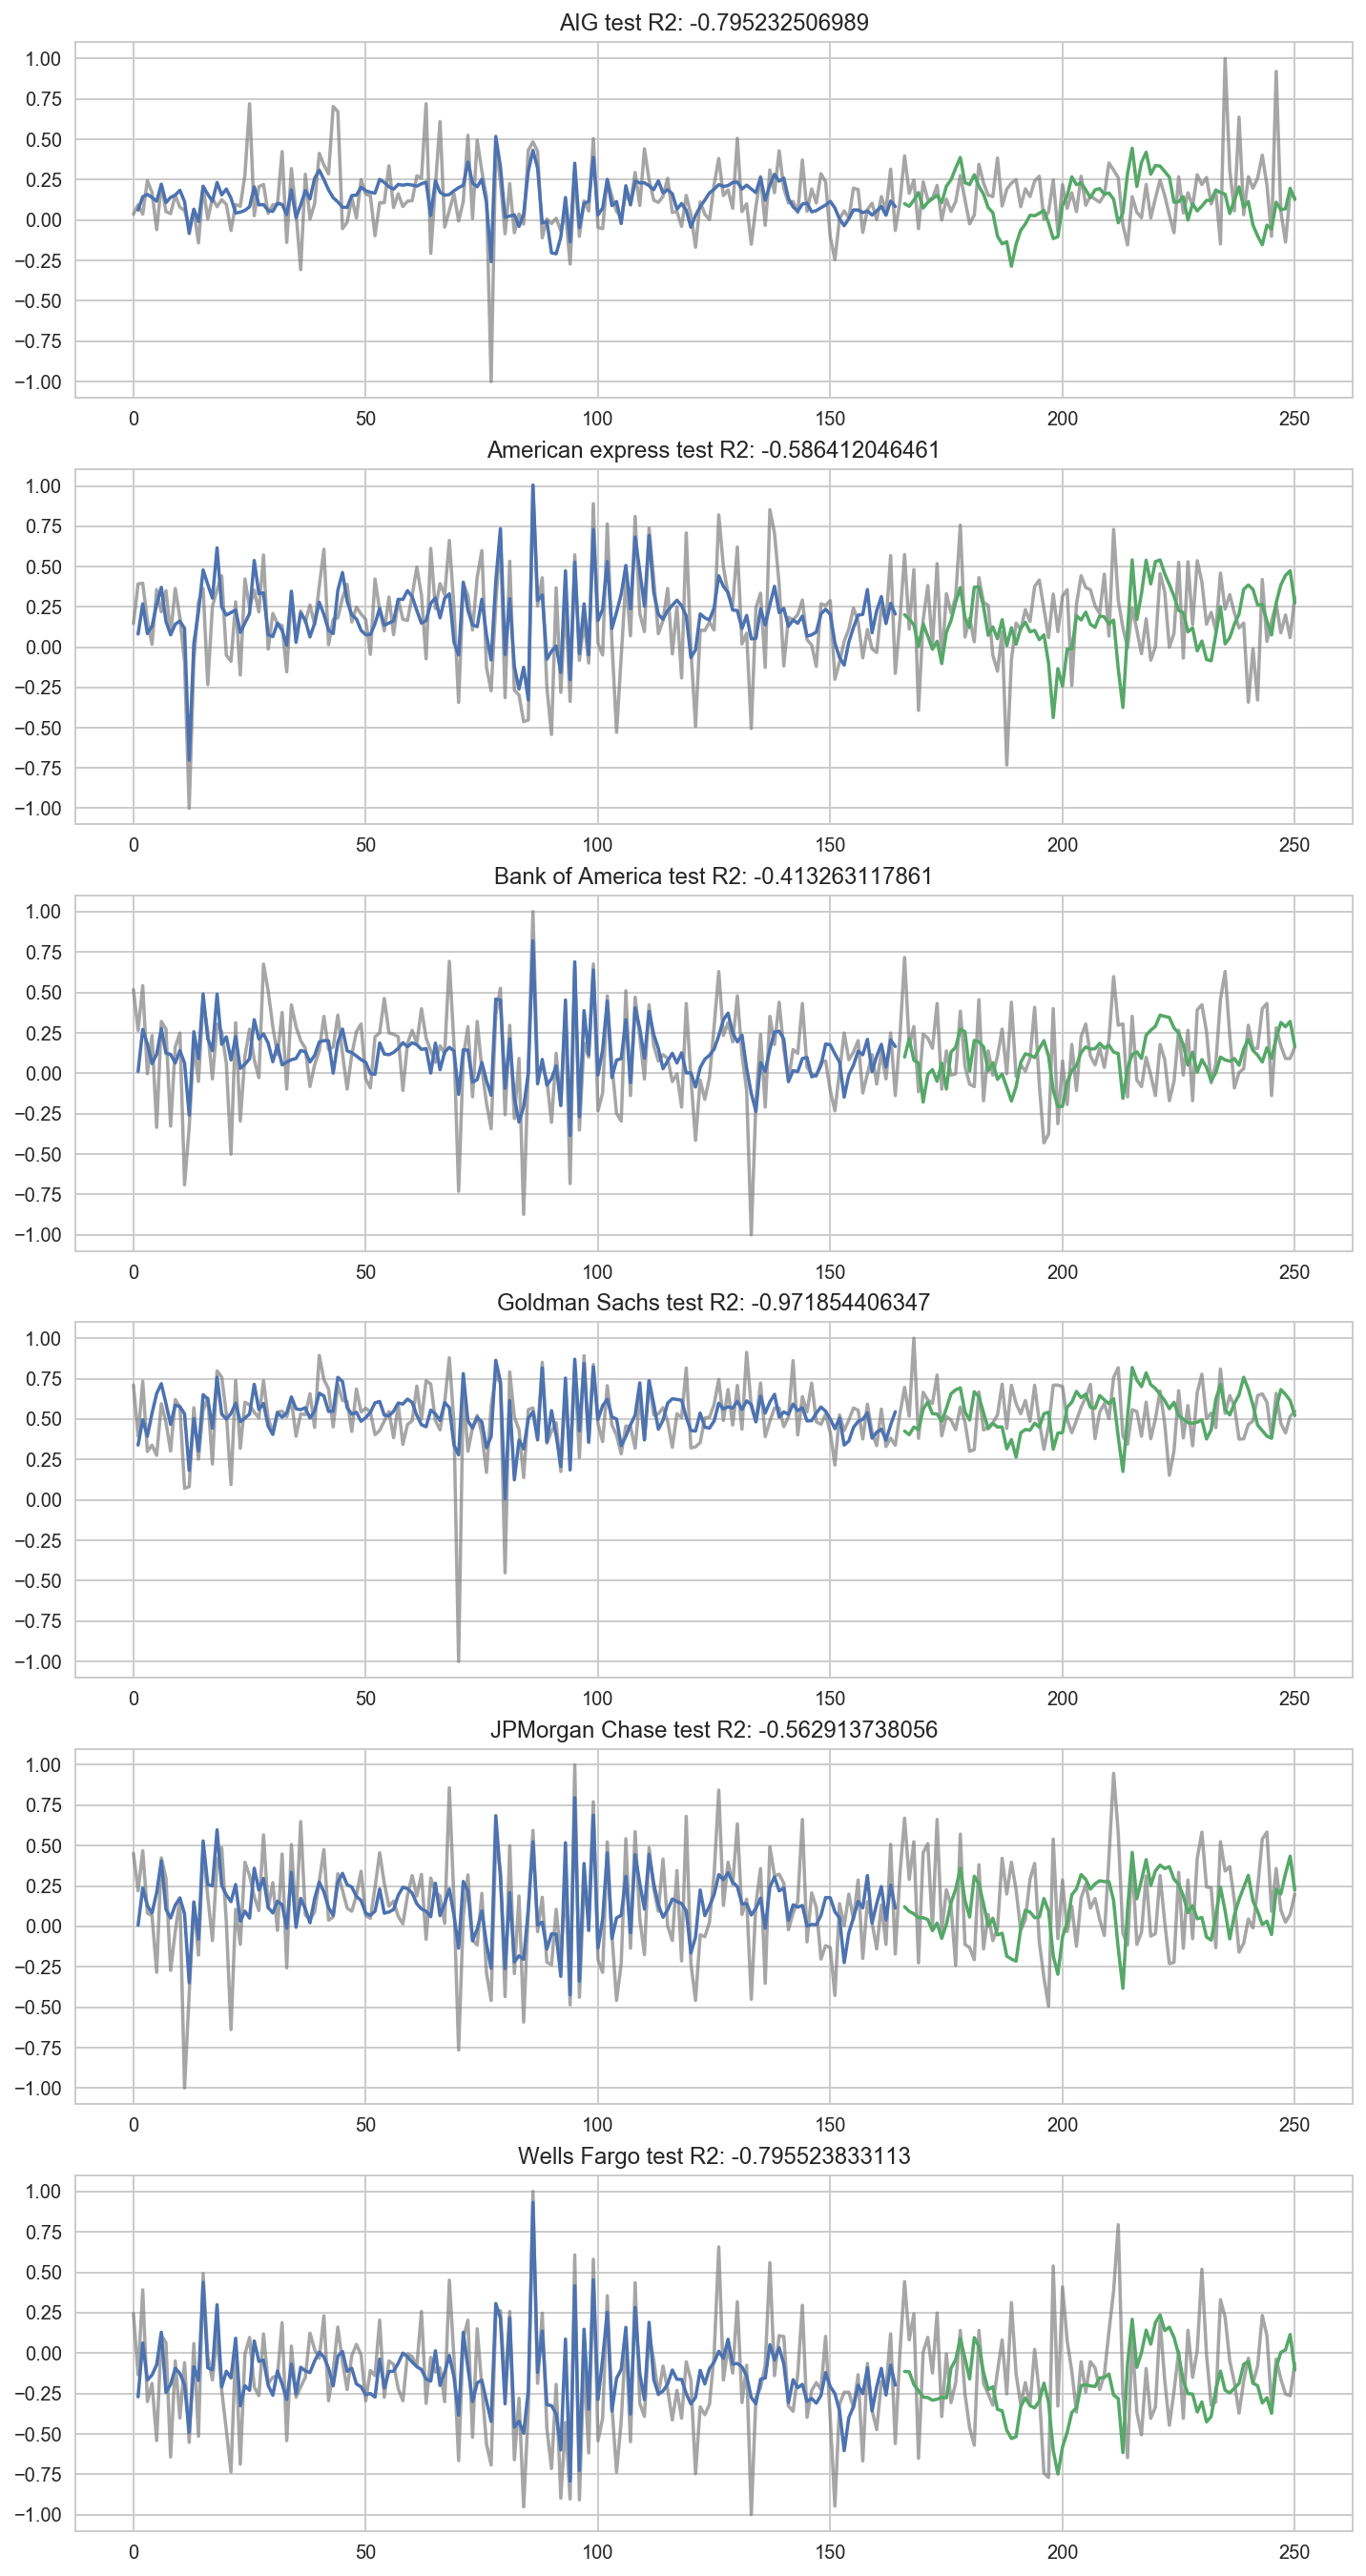

In [103]:
plot_all(model, Xtrain, Xtest, Ytest, bdfn, bank_names)

### 12. [Bonus] Build another LSTM model of your choice.

There are many ways you could change things up. Consider:
1. Changing the stocks in the predictor matrix or target.
2. Adding layers to the neural network architecture (check out the Keras documentation or examples!)

In [124]:
# create and fit the LSTM network
model = Sequential()
# Remember: "batch_input_shape" and specify the batch size
model.add(LSTM(64, batch_input_shape=(1, 1, Xtrain.shape[2]), 
               stateful=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(32, stateful=True, return_sequences=False))
model.add(Dense(Xtrain.shape[2]))
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (1, 1, 64)                18176     
_________________________________________________________________
lstm_14 (LSTM)               (1, 32)                   12416     
_________________________________________________________________
dense_8 (Dense)              (1, 6)                    198       
Total params: 30,790.0
Trainable params: 30,790
Non-trainable params: 0.0
_________________________________________________________________


In [125]:
for i in range(1000):
    if (i % 50) == 0:
        print 'ITER:', i
        model.fit(Xtrain, Ytrain, nb_epoch=1, batch_size=1, verbose=1, shuffle=False)
    else:
        model.fit(Xtrain, Ytrain, nb_epoch=1, batch_size=1, verbose=0, shuffle=False)
    model.reset_states()

ITER: 0
Epoch 1/1
164/164 [==============================] - 4s - loss: 0.0875     
ITER: 50
Epoch 1/1
164/164 [==============================] - 1s - loss: 0.0804     
ITER: 100
Epoch 1/1
164/164 [==============================] - 1s - loss: 0.0830     
ITER: 150
Epoch 1/1
164/164 [==============================] - 1s - loss: 0.0752     
ITER: 200
Epoch 1/1
164/164 [==============================] - 1s - loss: 0.0827     
ITER: 250
Epoch 1/1
164/164 [==============================] - 1s - loss: 0.0725     
ITER: 300
Epoch 1/1
164/164 [==============================] - 1s - loss: 0.0746     
ITER: 350
Epoch 1/1
164/164 [==============================] - 1s - loss: 0.0697     
ITER: 400
Epoch 1/1
164/164 [==============================] - 1s - loss: 0.0695     
ITER: 450
Epoch 1/1
164/164 [==============================] - 1s - loss: 0.0720     
ITER: 500
Epoch 1/1
164/164 [==============================] - 1s - loss: 0.0689     
ITER: 550
Epoch 1/1
164/164 [============================

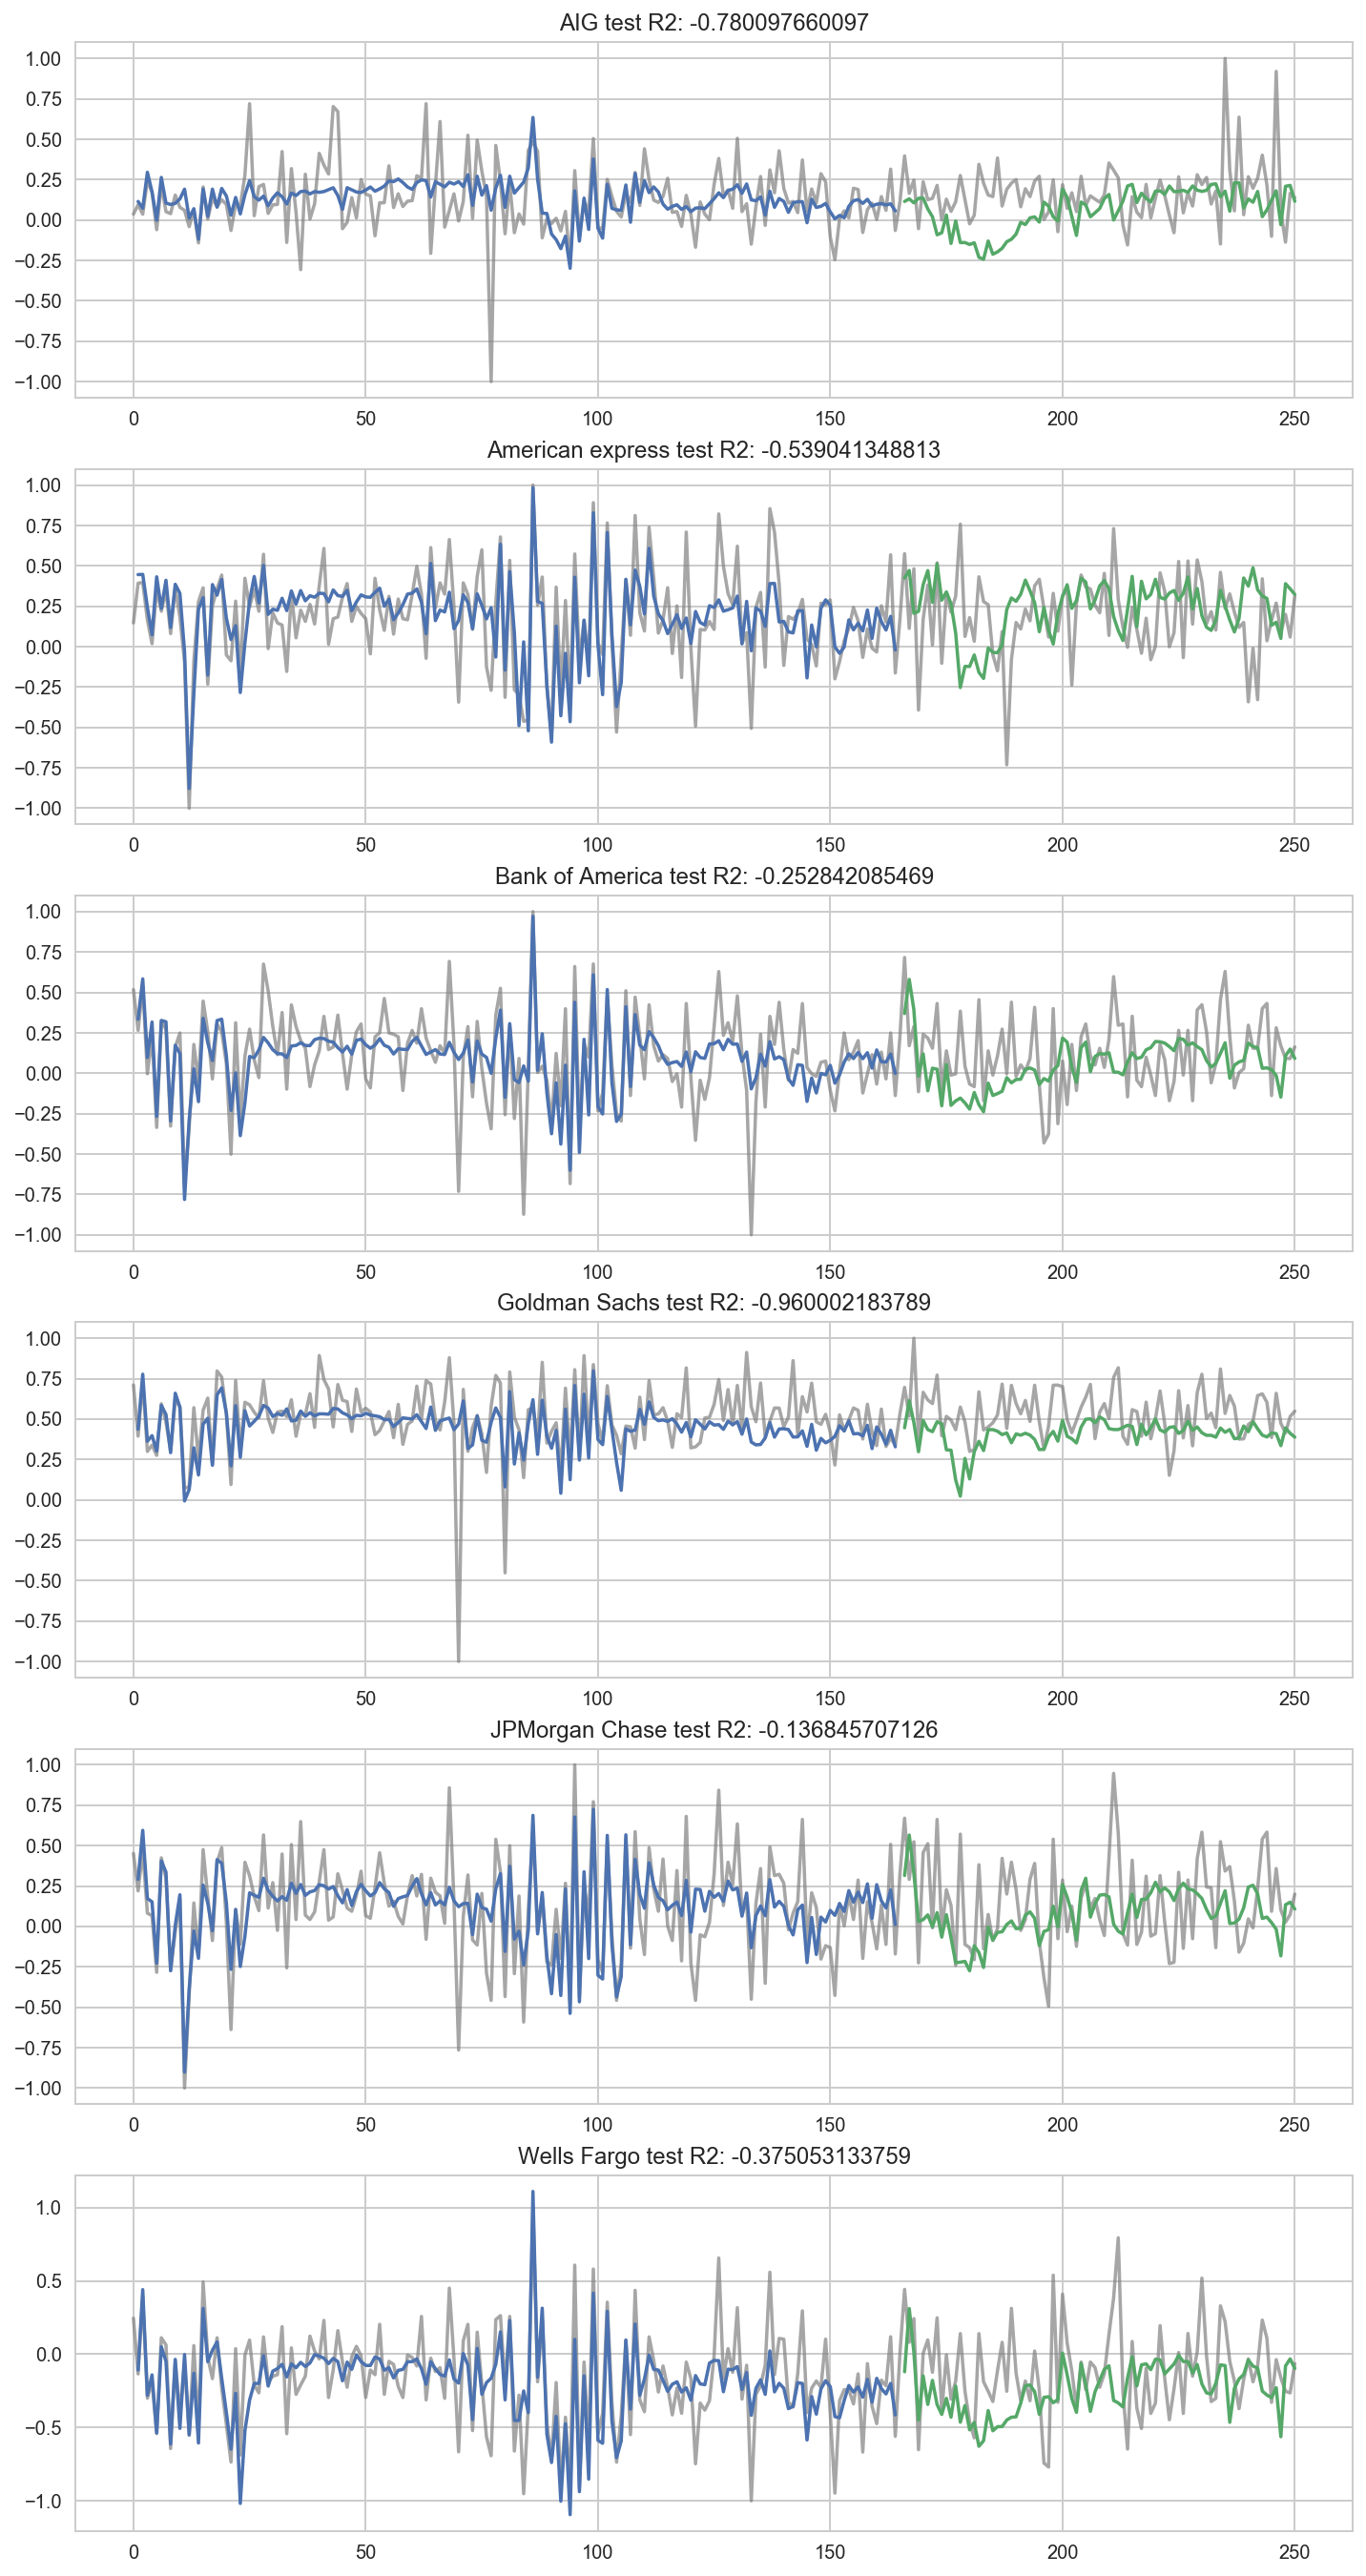

In [126]:
plot_all(model, Xtrain, Xtest, Ytest, bdfn, bank_names)